In [1]:
## ensemble

In [2]:
# limpio la memoria
Sys.time()
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

[1] "2025-12-01 18:58:59 UTC"

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,659104,35.2,1454590,77.7,1454590,77.7
Vcells,1224124,9.4,8388608,64.0,1975163,15.1


In [3]:
setwd("~")

In [4]:
Sys.time()
require( "data.table" )

# leo el dataset
dataset1 <- fread("~/datasets/competencia_02_crudo.csv.gz" )
dataset2<- fread("~/datasets/competencia_03_crudo.csv.gz" )

dataset <- rbind(dataset1, dataset2)


# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
  "pos" = .I,
  numero_de_cliente,
  periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 )
]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
  shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente
]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
  ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
  clase_ternaria := "BAJA+1"
]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
  & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
  clase_ternaria := "BAJA+2"
]

# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

rm(dsimple)
gc()
Sys.time()

[1] "2025-12-01 18:59:01 UTC"

Loading required package: data.table



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,768050,41.1,1454590,77.7,1454590,77.7
Vcells,1301333791,9928.4,1777923846,13564.5,1449739582,11060.7


[1] "2025-12-01 18:59:35 UTC"

In [22]:
# 1) Traer dataset del mes y ganancia real
dfuture <- dataset[foto_mes == 202107]
dfuture[, ganancia := ifelse(clase_ternaria=="BAJA+2", 780000, -20000)]


# 2) Traer archivo de predicciones en test
files <- list.files("/home/guadalesandro/buckets/b1/exp",   #"/home/guadalesandro/buckets/b1/exp/prueba",
                    pattern="^prediccion_mid\\.txt$", 
                    recursive=TRUE,
                    full.names=TRUE)


# coincidencia exacta: ^prediccion_mid\\.txt$
# empieza por: ^prediccion_mid
# termina por: \\.txt$
# contiene: mid\\.txt




# 3) leer todos los archivos con header=TRUE
pred_list <- lapply(files, function(f){
  fread(f, sep="\t", header=TRUE, encoding="UTF-8")
})

pred <- rbindlist(pred_list, use.names=TRUE, fill=TRUE)


# 4) Une la predicción y la ganancia real por número de cliente

pred[, numero_de_cliente := as.character(numero_de_cliente)]
dfuture[, numero_de_cliente := as.character(numero_de_cliente)]
pred[, prob := as.numeric(prob)]


pred <- merge(
  pred[, .(numero_de_cliente, prob)],
  dfuture[, .(numero_de_cliente, ganancia)],
  by = "numero_de_cliente",
  all.x = TRUE
)

# 4) Promedia la probabilidad por cliente
pred_ensamble <- pred[, .(
  prob_mean = mean(prob),
  ganancia = first(ganancia)
), by = numero_de_cliente]

# 5) Ordenar y ganancia acumulada
setorder(pred_ensamble, -prob_mean)
pred_ensamble[, gan_acum := cumsum(ganancia)]

# 6) Ganancia final de los 11000 más probables
envios <- 11500
ganancia_final <- pred_ensamble[envios, gan_acum]
ganancia_final

print(files)

[1] 422800000

 [1] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_b2/prediccion_mid.txt"
 [2] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_d/prediccion_mid.txt" 
 [3] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_e/prediccion_mid.txt" 
 [4] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_e2/prediccion_mid.txt"
 [5] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_f/prediccion_mid.txt" 
 [6] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_h/prediccion_mid.txt" 
 [7] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_j/prediccion_mid.txt" 
 [8] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_k/prediccion_mid.txt" 
 [9] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_k2/prediccion_mid.txt"
[10] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_k3/prediccion_mid.txt"
[11] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_k4/prediccion_mid.txt"
[12] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_k5/prediccion_mid.txt"
[13] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_k6/prediccion_mid.txt"
[14] "/home/guadalesandro

In [23]:
# ====== 7) Métricas del ensamble ======

# Clase real: 1 si BAJA+2 (ganancia positiva)
pred_ensamble[, clase_real := ifelse(ganancia == 780000, 1, 0)]

# Clase predicha: 1 para los 11500 más probables
pred_ensamble[, clase_pred := 0]
pred_ensamble[1:envios, clase_pred := 1]

# Matriz de confusión
TP <- pred_ensamble[clase_real == 1 & clase_pred == 1, .N]
FP <- pred_ensamble[clase_real == 0 & clase_pred == 1, .N]
TN <- pred_ensamble[clase_real == 0 & clase_pred == 0, .N]
FN <- pred_ensamble[clase_real == 1 & clase_pred == 0, .N]

# Métricas
accuracy  <- (TP + TN) / (TP + TN + FP + FN)
precision <- TP / (TP + FP)
recall    <- TP / (TP + FN)
f1        <- 2 * precision * recall / (precision + recall)

# Mostrar resultados
list(
  ganancia_final = ganancia_final,
  accuracy  = accuracy,
  precision = precision,
  recall    = recall,
  f1        = f1,
  TP = TP, FP = FP, TN = TN, FN = FN
)


$ganancia_final
[1] 422800000

$accuracy
[1] 0.9324649

$precision
[1] 0.07095652

$recall
[1] 0.6538462

$f1
[1] 0.1280201

$TP
[1] 816

$FP
[1] 10684

$TN
[1] 152664

$FN
[1] 432

In [25]:
# ========= 7) Métricas por cada modelo individual ==========

# 7.1 volver a cargar cada archivo y agregar el nombre del modelo
pred_list <- lapply(files, function(f){
  df <- fread(f, sep="\t", header=TRUE, encoding="UTF-8")

# Extrae el nombre del archivo, quita la extensión .txt
#  model_name <- sub("\\.txt$", "", basename(f))
#  df[, modelo := model_name] # <--- CAMBIO AQUÍ

  # nombre de la carpeta del experimento como identificador del modelo
  df[, modelo := basename(dirname(f))]

  df
})

pred_all <- rbindlist(pred_list, use.names=TRUE, fill=TRUE)

# 7.2 corregir tipos y unir con la verdad real
pred_all[, numero_de_cliente := as.character(numero_de_cliente)]
pred_all[, prob := as.numeric(prob)]

dfuture2 <- copy(dfuture)
dfuture2[, numero_de_cliente := as.character(numero_de_cliente)]

pred_all <- merge(
  pred_all,
  dfuture2[, .(numero_de_cliente, ganancia)],
  by = "numero_de_cliente",
  all.x = TRUE
)

# clase real binaria
pred_all[, clase_real := ifelse(ganancia == 780000, 1, 0)]

envios <- 11500

# 7.3 calcular métricas por cada modelo
metricas_modelo <- pred_all[
  , {
      # ordenar por prob en este modelo
      dt <- .SD[order(-prob)]

      # clase predicha según el top K
      dt[, clase_pred := 0]
      dt[1:envios, clase_pred := 1]

      TP <- dt[clase_real == 1 & clase_pred == 1, .N]
      FP <- dt[clase_real == 0 & clase_pred == 1, .N]
      TN <- dt[clase_real == 0 & clase_pred == 0, .N]
      FN <- dt[clase_real == 1 & clase_pred == 0, .N]

      accuracy  <- (TP + TN) / (TP + TN + FP + FN)
      precision <- TP / (TP + FP)
      recall    <- TP / (TP + FN)
      f1        <- 2 * precision * recall / (precision + recall)

      list(
        accuracy = accuracy,
        precision = precision,
        recall = recall,
        f1 = f1,
        TP = TP, FP = FP, TN = TN, FN = FN
      )
    },
  by = modelo
]

metricas_modelo


modelo,accuracy,precision,recall,f1,TP,FP,TN,FN
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
apo-505_C3_b2,0.9324892,0.07113043,0.6554487,0.1283339,818,10682,152666,430
apo-505_C3_d,0.9323313,0.07000000,0.6450321,0.1262943,805,10695,152653,443
apo-505_C3_e,0.9324406,0.07078261,0.6522436,0.1277063,814,10686,152662,434
apo-505_C3_e2,0.9324892,0.07113043,0.6554487,0.1283339,818,10682,152666,430
apo-505_C3_f,0.9324528,0.07086957,0.6530449,0.1278632,815,10685,152663,433
apo-505_C3_h,0.9323920,0.07043478,0.6490385,0.1270788,810,10690,152658,438
apo-505_C3_j,0.9324042,0.07052174,0.6498397,0.1272356,811,10689,152659,437
apo-505_C3_k,0.9325986,0.07191304,0.6626603,0.1297458,827,10673,152675,421
apo-505_C3_k2,0.9325135,0.07130435,0.6570513,0.1286476,820,10680,152668,428


In [26]:
# Convertir de formato largo a ancho, con cada modelo en una columna
pred_wide <- dcast(
  pred_all,
  numero_de_cliente ~ modelo, # Clientes en filas, modelos en columnas
  value.var = "prob"
)

# Muestra las primeras filas (opcional)
head(pred_wide)

numero_de_cliente,apo-505_C3_b2,apo-505_C3_d,apo-505_C3_e,apo-505_C3_e2,apo-505_C3_f,apo-505_C3_h,apo-505_C3_j,apo-505_C3_k,apo-505_C3_k2,⋯,apo-505_C3_l2,apo-505_C3_m2,apo-505_C3_m3,apo-505_C3_n,apo-505_C3_n3,apo-505_C3_n4,apo-505_C3_n5,apo-505_C3_n6,apo-505_C3_o,apo-505_C3_p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000004722,0.050409404,0.053596065,0.17900998,0.0393122210,0.046198487,0.0097231522,0.0110863923,0.0555632396,0.0101174014,⋯,0.12867264,0.078103151,0.044774110,0.057725026,0.0514943788,6.771125e-03,0.0542680329,0.0603610251,0.063379474,0.1085813743
1000026523,0.001025926,0.001169065,0.01633918,0.0008021474,0.003503203,0.0001781708,0.0002013713,0.0007268905,0.0001673914,⋯,0.00857375,0.002605401,0.004106829,0.000317019,0.0007476191,7.215524e-05,0.0006346938,0.0008454545,0.001792292,0.0003228596
1000028641,0.006218572,0.003951733,0.02779675,0.0057495804,0.005044712,0.0005255181,0.0006016650,0.0044085952,0.0005526026,⋯,0.01843310,0.006220897,0.004412741,0.003181236,0.0053754400,7.203026e-04,0.0047488922,0.0034485449,0.008434755,0.0037579945
1000032356,0.012717510,0.015511118,0.05504729,0.0143599036,0.011847149,0.0027221669,0.0027109078,0.0136619011,0.0026101172,⋯,0.02579506,0.013087954,0.008733955,0.003680149,0.0064143328,9.781329e-04,0.0073895065,0.0125899046,0.021774513,0.0138302174
1000034406,0.165943053,0.244517794,0.20692763,0.1739351704,0.060244037,0.0315287803,0.0445033893,0.1159199790,0.0350465600,⋯,0.22501796,0.160075386,0.051296342,0.119722897,0.1252851376,2.598591e-02,0.1320957010,0.1417363544,0.191723468,0.1081765503
1000035055,0.041503461,0.031662326,0.06984711,0.0180574327,0.017481223,0.0039593406,0.0048652743,0.0293358711,0.0052923392,⋯,0.07818258,0.075719836,0.025721016,0.059290729,0.0445693969,8.574770e-03,0.0705359814,0.0308334422,0.048906148,0.0468280082


In [27]:
# Extraer solo las columnas de probabilidad para el cálculo
prob_matrix <- as.matrix(pred_wide[, -c("numero_de_cliente")])

# Calcular la matriz de correlación de Pearson
cor_matrix <- cor(prob_matrix, use = "pairwise.complete.obs") 

# Imprimir la matriz
print(cor_matrix)

              apo-505_C3_b2 apo-505_C3_d apo-505_C3_e apo-505_C3_e2
apo-505_C3_b2     1.0000000    0.9930931    0.9779402     0.9949929
apo-505_C3_d      0.9930931    1.0000000    0.9736430     0.9929935
apo-505_C3_e      0.9779402    0.9736430    1.0000000     0.9733728
apo-505_C3_e2     0.9949929    0.9929935    0.9733728     1.0000000
apo-505_C3_f      0.9376770    0.9362056    0.9212417     0.9376594
apo-505_C3_h      0.9041489    0.9036765    0.8689347     0.9063729
apo-505_C3_j      0.9095748    0.9089053    0.8753257     0.9115472
apo-505_C3_k      0.9973382    0.9925554    0.9751159     0.9947887
apo-505_C3_k2     0.9082945    0.9064558    0.8727367     0.9089679
apo-505_C3_k3     0.9037245    0.9031583    0.8684972     0.9058225
apo-505_C3_k4     0.9971125    0.9920045    0.9822346     0.9933648
apo-505_C3_k5     0.9927099    0.9871648    0.9919549     0.9876068
apo-505_C3_k6     0.9756219    0.9696090    0.9666800     0.9706943
apo-505_C3_k7     0.9963467    0.9936300    0.97

In [28]:
install.packages("corrplot")
library(corrplot)

Installing package into ‘/home/guadalesandro/.local/lib/R/site-library’
(as ‘lib’ is unspecified)

corrplot 0.95 loaded



In [29]:
# Paso 1: Convertir de formato largo a ancho
pred_wide <- dcast(
  pred_all,
  numero_de_cliente ~ modelo, 
  value.var = "prob"
)

# Paso 2: Calcular la matriz de correlación
prob_matrix <- as.matrix(pred_wide[, -c("numero_de_cliente")])
cor_matrix <- cor(prob_matrix, use = "pairwise.complete.obs")

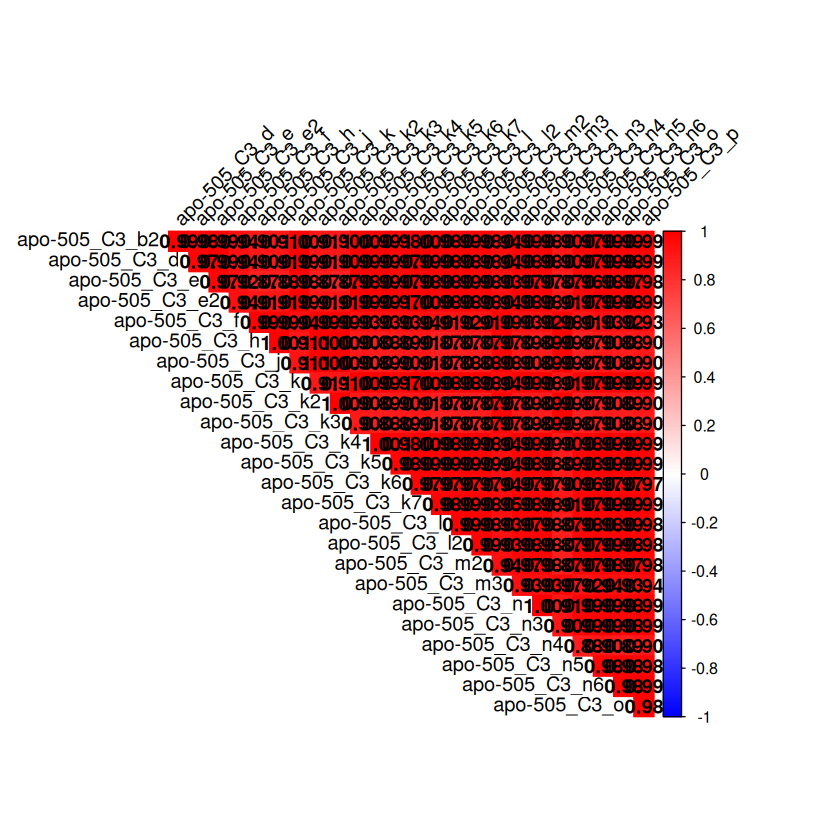

In [31]:
# Visualizar la matriz como un mapa de calor
corrplot(
  cor_matrix, 
  method = "color",       # Usa color para representar la correlación
  type = "upper",         # Muestra solo la parte superior (es simétrica)
  diag = FALSE,           # No muestra la correlación de un modelo consigo mismo (es siempre 1)
  addCoef.col = "black",  # Agrega el valor numérico de la correlación
  tl.col = "black",       # Color de las etiquetas (nombres de los modelos)
  tl.srt = 45,            # Gira las etiquetas para mejor legibilidad
  col = colorRampPalette(c("blue", "white", "red"))(200) # Usa una paleta de colores para mejor contraste
)

In [ ]:
## predicción final ensamble

In [21]:
dfuture <- dataset[foto_mes == 202109]

In [28]:
# 1 - Levanta predicciones y las concatena
files <- list.files("/home/guadalesandro/buckets/b1/exp", #/C3
                    pattern="^prediccion\\.txt$",
                    recursive=TRUE,
                    full.names=TRUE)

print(files)

pred_list <- lapply(files, function(f){
  fread(f, sep="\t", header=TRUE, encoding="UTF-8")})
pred <- rbindlist(pred_list, use.names=TRUE, fill=TRUE)


pred[, numero_de_cliente := as.character(numero_de_cliente)]
pred[, prob := as.numeric(prob)]

#promedia probabilidades y las ordena
pred_ensamble <- pred[, .(prob_mean = mean(prob, na.rm=TRUE)), by = numero_de_cliente]
setorder(pred_ensamble, -prob_mean)

# Filtrar solo clientes de dfuture
clientes_future <- unique(dfuture$numero_de_cliente)
pred_ensamble <- pred_ensamble[numero_de_cliente %in% clientes_future]


envios <- 11500
pred_ensamble[, Predicted := 0L]
pred_ensamble[1:envios, Predicted := 1L]

cat("Cantidad de registros en el archivo final:", nrow(pred_ensamble), "\n")

#Guarda el archivo en carpeta final
output_dir <- "/home/guadalesandro/dmeyf2025/babycode/R_C3/C3_final"

# crear la carpeta si no existe
if(!dir.exists(output_dir)) dir.create(output_dir, recursive = TRUE)
archivo_final <- file.path(output_dir, "C3_final_Alesandro.csv")

fwrite(
  pred_ensamble[, .(numero_de_cliente, Predicted)],
  file = archivo_final,
  sep = ","
)

cat("Archivo guardado en:", archivo_final, "\n")


 [1] "/home/guadalesandro/buckets/b1/exp/apo-505_a/prediccion.txt"                                                 
 [2] "/home/guadalesandro/buckets/b1/exp/apo-505_a2/prediccion.txt"                                                
 [3] "/home/guadalesandro/buckets/b1/exp/apo-505_base_integrada/prediccion.txt"                                    
 [4] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_b/prediccion.txt"                                              
 [5] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_c/prediccion.txt"                                              
 [6] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_d/prediccion.txt"                                              
 [7] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_e/prediccion.txt"                                              
 [8] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_e2/prediccion.txt"                                             
 [9] "/home/guadalesandro/buckets/b1/exp/apo-505_C3_f/prediccion.txt"   